# Задача с непрерывным спектром действий в непрерывной среде

In [95]:
import gymnasium as gym
import numpy as np
import torch
import copy
import random
import torch.nn as nn
from torch.nn import functional as f
from tqdm import tqdm
from collections import namedtuple, deque

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

# A2C

## Алгоритм

Создадим классы для двух сеток.

In [150]:
class VNet(nn.Module):
    def __init__(self, n_input, hidden_dim):
        super().__init__()

        self.hidden = nn.Linear(n_input, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = f.relu(outs)
        outs = self.output(outs)
        return outs


class PolicyNet(nn.Module):
    def __init__(self, n_input, n_output, hidden_dim):
        super().__init__()
        self.hidden = nn.Linear(n_input, hidden_dim)
        self.mu = nn.Linear(hidden_dim, n_output)
        self.sigma = nn.Linear(hidden_dim, n_output)

    def forward(self, s):
        x = f.relu(self.hidden(s))
        mu = 2 * torch.tanh(self.mu(x))
        sigma = f.softplus(self.sigma(x)) + 1e-5
        return torch.distributions.Normal(mu, sigma)

Класс актор-критик.

In [151]:
class A2C():
    def __init__(self, n_input, n_output, hidden_dim, lr):
        # Сетки
        self.critic = VNet(n_input=n_input, hidden_dim=hidden_dim).to(device)
        self.actor = PolicyNet(n_input=n_input, n_output=n_output, hidden_dim=hidden_dim).to(device)
        # Оптимизаторы
        self.opt_actor = torch.optim.AdamW(self.actor.parameters(), lr=lr)
        self.opt_critic = torch.optim.AdamW(self.critic.parameters(), lr=lr)

    
    def get_action(self, s):
        s_tensor = torch.Tensor(s).to(device)
        dist = self.actor(s_tensor)
        action = dist.sample().detach().cpu().data.numpy()
        return action

    
    def update_critic(self, states, cum_rewards):
        self.opt_critic.zero_grad()
        
        values = self.critic(states).squeeze(dim=1)
        vf_loss = f.mse_loss(
            values,
            cum_rewards,
            reduction='none'
        )
        vf_loss.sum().backward()
        self.opt_critic.step()

    
    def update_actor(self, actions, states, cum_rewards):        
        with torch.no_grad():
            values = self.critic(states).squeeze(dim=1)
    
        norm_dists = self.actor(states)
        log_probs = norm_dists.log_prob(actions)

        advantages = cum_rewards - values
        policy_loss = -log_probs * advantages

        self.opt_actor.zero_grad()
        policy_loss.sum().backward()
        self.opt_actor.step()

Функция для обучения агента.

In [156]:
def learn_a2c_agent_continuous(env, num_episodes, gamma=0.99, lr=0.001):
    n_observations = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    
    total_rewards = []
    avg_rewards_last_100_episodes = []

    estimator = A2C(n_input=n_observations, n_output=n_actions, hidden_dim=128, lr=lr)

    for i in tqdm(range(num_episodes)):
        # в начале эпизода обнуляем массивы и сбрасываем среду
        is_done = False
        states = []
        actions = []
        rewards = []
        state, _ = env.reset()

        # пока не достигнем конечного состояния продолжаем выполнять действия
        while not is_done:
            states.append(state.tolist())
            action = estimator.get_action(state)
            action = action.clip(env.action_space.low[0], env.action_space.high[0])
            state, reward, terminated, truncacted, _ = env.step(action)
            print(action, reward)
            is_done = terminated or truncacted
            actions.append(action)
            rewards.append(reward)

        # Формируем массив полной награды для каждого состояния
        cum_rewards = np.zeros_like(rewards)
        reward_len = len(rewards)
        for j in reversed(range(reward_len)):
            cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

        # Приведем все списки к тензорам
        cum_rewards = torch.Tensor(cum_rewards).to(device)
        states = torch.Tensor(states).to(device)
        actions = torch.Tensor(actions).to(device)

        # Оптимизурем веса критика
        estimator.update_critic(states=states, cum_rewards=cum_rewards)

        # Оптимизируем веса актора
        estimator.update_actor(actions=actions, states=states, cum_rewards=cum_rewards)

        # Выводим итоговую награду в эпизоде
        total_rewards.append(sum(rewards))
        avg_rewards_last_100_episodes.append(np.mean(total_rewards[-100:]))

        if i % 100 == 0:
            print("Run episode {} with average reward {}".format(i, np.mean(total_rewards[-100:])), end="\r")

    return estimator, total_rewards, avg_rewards_last_100_episodes

## Обучение агента в среде mountain car

In [153]:
env = gym.make('MountainCarContinuous-v0')

In [154]:
env.observation_space.shape[0]

2

In [155]:
env.action_space.shape[0]

1

In [9]:
estimator, total_rewards, avg_rewards_last_100_episodes = learn_a2c_agent_continuous(
    env=env, num_episodes=1000, gamma=0.99, lr=0.001
)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\rus95\AppData\Local\Temp\ipykernel_18124\1477063510.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  actions = torch.Tensor(actions).to(device)
  0%|                                                                                 | 1/1000 [00:02<34:11,  2.05s/it]

 10%|███████▉                                                                       | 101/1000 [01:51<11:39,  1.28it/s]

 20%|███████████████▉                                                               | 201/1000 [04:08<14:28,  1.09s/it]

 30%|███████████████████████▊                                                       | 301/1000 [05:52<13:38,  1.17s/it]

 40%|███████████████████████████████▋                                               | 401/1000 [08:04<13:46,  1.38s/it]

 50%|███████████████████████████████████████▌                                       | 501/1000 [10:15<07:53,  1.05it/s]

 60%|███████████████████████████████████████████████▍                               | 601/1000 [11:53<04:53,  1.36it/s]

 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [14:02<05:08,  1.03s/it]

 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [16:03<04:04,  1.23s/it]

 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [18:19<01:48,  1.10s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:37<00:00,  1.24s/it]


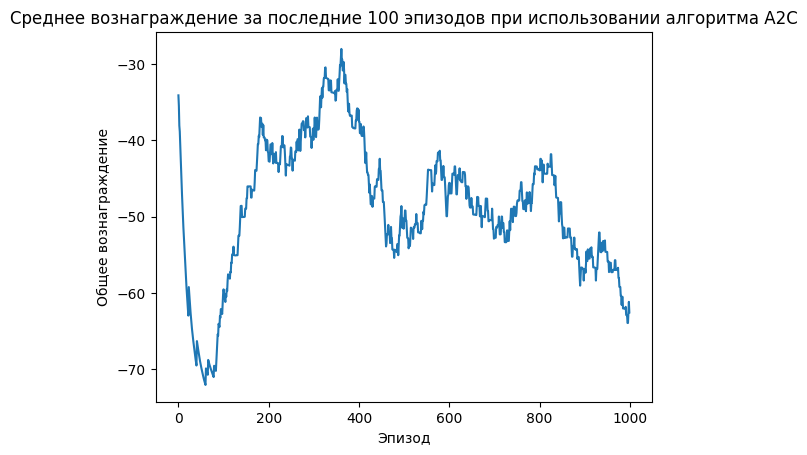

In [10]:
plt.plot(avg_rewards_last_100_episodes)
plt.title('Среднее вознаграждение за последние 100 эпизодов при использовании алгоритма A2C')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

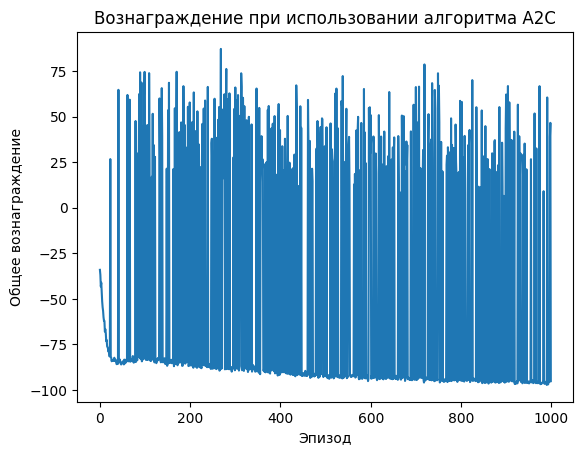

In [11]:
plt.plot(total_rewards)
plt.title('Вознаграждение при использовании алгоритма A2C')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

## Алгоритм v2

In [12]:
class ActorCriticModel(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(ActorCriticModel, self).__init__()
        self.hidden = nn.Linear(n_input, n_hidden)
        self.mu = nn.Linear(n_hidden, n_output)
        self.sigma = nn.Linear(n_hidden, n_output)
        self.value = nn.Linear(n_hidden, 1)
        self.distribution = torch.distributions.Normal

    def forward(self, s):
        x = f.relu(self.hidden(s))
        mu = 2 * torch.tanh(self.mu(x))
        sigma = f.softplus(self.sigma(x)) + 1e-5
        dist = self.distribution(mu.view(1, ).data, sigma.view(1, ).data)
        value = self.value(x)
        return dist, value

In [13]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = ActorCriticModel(n_state, n_action, n_hidden).to(device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr)

    
    def predict(self, s):
        self.model.training = False
        return self.model(torch.Tensor(s).to(device))


    def update(self, returns, log_probs, state_values):
        loss = 0
        for log_prob, value, Gt in zip(log_probs, state_values, returns):
            advantage = Gt - value.item()
            policy_loss = -log_prob * advantage
            value_loss = f.smooth_l1_loss(value, Gt)
            loss += policy_loss + value_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    
    def get_action(self, s):
        dist, state_value = self.predict(s)
        action = dist.sample()
        log_prob = dist.log_prob(action[0])
        return action.cpu().numpy(), log_prob, state_value

In [14]:
def actor_critic(env, estimator, n_episode, gamma=0.99):
    total_rewards = []
    avg_rewards_last_100_episodes = []
    
    for episode in tqdm(range(n_episode)):
        is_done = False
        log_probs = []
        rewards = []
        state_values = []
        state, _ = env.reset()
        while not is_done:
            action, log_prob, state_value = estimator.get_action(state)
            action = action.clip(env.action_space.low[0], env.action_space.high[0])
            next_state, reward, terminated, truncated, _ = env.step(action)
            log_probs.append(log_prob)
            state_values.append(state_value)
            rewards.append(reward)
            is_done = terminated or truncated
            
            if is_done:
                returns = []
                Gt = 0
                pw = 0
                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1
                    returns.append(Gt)
                returns = returns[::-1]
                returns = torch.Tensor(returns).to(device)
                estimator.update(returns, log_probs, state_values)
            state = next_state
            
        total_rewards.append(sum(rewards))
        avg_rewards_last_100_episodes.append(np.mean(total_rewards[-100:]))

        if episode % 100 == 0:
            print("Run episode {} with average reward {}".format(episode, np.mean(total_rewards[-100:])), end="\r")
    return estimator, total_rewards, avg_rewards_last_100_episodes

## Обучение агента в среде mountain car, v2

In [15]:
env = gym.make('MountainCarContinuous-v0')

In [16]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.shape[0]
n_hidden = 128
lr = 0.0005
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

In [17]:
estimator, total_rewards, avg_rewards_last_100_episodes = actor_critic(
    env=env, estimator=policy_net, n_episode=500, gamma=0.99
)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\rus95\AppData\Local\Temp\ipykernel_18124\3933484903.py:17: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = f.smooth_l1_loss(value, Gt)
  0%|▏                                                                                 | 1/500 [00:02<23:05,  2.78s/it]

 20%|████████████████▏                                                               | 101/500 [04:40<19:00,  2.86s/it]

 40%|████████████████████████████████▏                                               | 201/500 [09:20<13:36,  2.73s/it]

 60%|████████████████████████████████████████████████▏                               | 301/500 [14:00<08:56,  2.70s/it]

 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [18:38<04:43,  2.87s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [23:16<00:00,  2.79s/it]


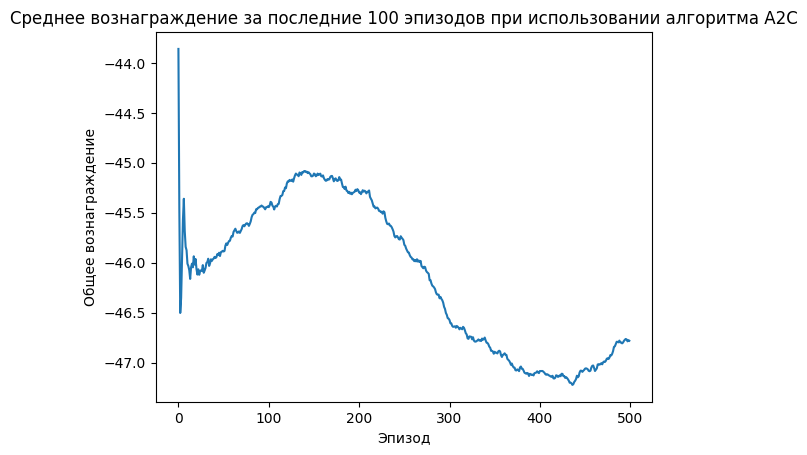

In [18]:
plt.plot(avg_rewards_last_100_episodes)
plt.title('Среднее вознаграждение за последние 100 эпизодов при использовании алгоритма A2C')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

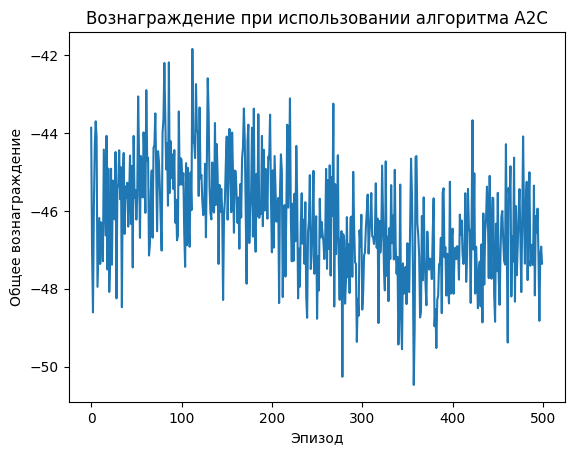

In [19]:
plt.plot(total_rewards)
plt.title('Вознаграждение при использовании алгоритма A2C')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

# DDPG

## Алгоритм

Определим классы для Q-функции и для политики.

In [325]:
class QNet(nn.Module):
    def __init__(self, n_input, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(n_input, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s, a):
        outs = torch.concat((s, a), dim=-1)
        outs = self.hidden(outs)
        outs = f.relu(outs)
        outs = self.output(outs)
        return outs


class PolicyNet(nn.Module):
    def __init__(self, n_input, n_output, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(n_input, hidden_dim)
        self.output = nn.Linear(hidden_dim, n_output)

    def forward(self, s):
        outs = self.hidden(s)
        outs = f.relu(outs)
        outs = self.output(outs)
        outs = torch.tanh(outs)
        return outs

Класс для шума.

In [326]:
class OrnsteinUhlenbeckActionNoise():
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

Класс ReplayBuffer

In [327]:
class replayBuffer():
    def __init__(self, replay_capacity: int):
        self.memory = deque([], maxlen=replay_capacity)

    def add(self, items_tuple):
        self.memory.append(items_tuple)

    def sample(self, replay_size):
        replay_data = random.sample(self.memory, replay_size)
        states = [data[0] for data in replay_data]
        actions = [data[1] for data in replay_data]
        rewards = [data[2] for data in replay_data]
        n_states = [data[3] for data in replay_data]
        dones = [data[4] for data in replay_data]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.memory)

Класс DDPG

In [328]:
class DDPG():
    def __init__(self, n_input, n_output, hidden_dim=64, lr=0.0005):
        self.q_model = QNet(n_input=n_input+n_output, hidden_dim=hidden_dim).to(device)
        self.q_model_target = copy.deepcopy(self.q_model)
        self.q_model_target.requires_grad_(False)
        
        self.policy_model = PolicyNet(n_input=n_input, n_output=n_output, hidden_dim=hidden_dim).to(device)
        self.policy_model_target = copy.deepcopy(self.policy_model)
        self.policy_model_target.requires_grad_(False)

        self.opt_q = torch.optim.AdamW(self.q_model.parameters(), lr=lr)
        self.opt_policy = torch.optim.AdamW(self.policy_model.parameters(), lr=lr)


    def get_action(self, s, noise, lower, upper):
        with torch.no_grad():
            s = np.array(s)
            s_batch = np.expand_dims(s, axis=0)
            s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
            action_det = self.policy_model(s_batch).squeeze(dim=1)
            action = np.clip(action_det.cpu().numpy() + noise, lower, upper)
            return float(action.item())


    def optimize(self, states, actions, rewards, next_states, dones, gamma):
        # Convert to tensor
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions, dtype=torch.float).to(device).unsqueeze(dim=1)
        rewards = torch.tensor(rewards, dtype=torch.float).to(device).unsqueeze(dim=1)
        next_states = torch.tensor(next_states, dtype=torch.float).to(device)
        dones = torch.tensor(dones, dtype=torch.float).to(device).unsqueeze(dim=1)
    
        # Optimize critic loss
        self.opt_q.zero_grad()
        # Предикты Q-сетки на текущем шаге
        q_pred = self.q_model(states, actions)
        # Предикты целевой Q-сетки на следующем шаге
        policy_next_actions = self.policy_model_target(next_states)
        q_tgt_next = self.q_model_target(next_states, policy_next_actions)
        # Создаем таргет для Q-сетки
        q_tgt = rewards + gamma * (1.0 - dones) * q_tgt_next
        loss_q = f.mse_loss(
            q_pred,
            q_tgt,
            reduction="none")
        loss_q.sum().backward()
        self.opt_q.step()
    
        # Optimize actor loss
        self.opt_policy.zero_grad()
        # Определяем действия по текущей политике
        policy_actions = self.policy_model(states)
        # Замораживаем Q-сетку, получаем Q значения для состояний
        for p in self.q_model.parameters():
            p.requires_grad = False
        q_tgt_max = self.q_model(states, policy_actions)
        # Обновляем веса сетки политики (в сторону максимизации значений Q-функции)
        (-q_tgt_max).sum().backward()
        self.opt_policy.step()
        for p in self.q_model.parameters():
            p.requires_grad = True


    def update_target(self, tau):
        q_net_state = self.q_model.state_dict()
        q_net_target_state = self.q_model_target.state_dict()
        for key in q_net_state:
            q_net_target_state[key] = q_net_state[key] * tau + q_net_target_state[key] * (1 - tau)
        self.q_model_target.load_state_dict(q_net_target_state)

        policy_net_state = self.policy_model.state_dict()
        policy_net_target_state = self.policy_model_target.state_dict()
        for key in policy_net_state:
            policy_net_target_state[key] = policy_net_state[key] * tau + policy_net_target_state[key] * (1 - tau)
        self.policy_model_target.load_state_dict(policy_net_target_state)

Алгоритм обучения агента.

In [329]:
def learn_agent_ddpg(env, n_episode, gamma=0.99, tau=0.002, batch_size=264, hidden_dim=64, lr=0.0005, noise_decay=0.001):
    # Базовые параметры среды
    n_observations, n_actions = env.observation_space.shape[0], env.action_space.shape[0]
    lower_action, upper_action = env.action_space.low[0], env.action_space.high[0]

    # Списки, где храним результаты
    total_rewards = []
    avg_rewards_last_100_episodes = []
    lengths = []

    # Экземпляр буффера и эстиматора
    buffer = replayBuffer(replay_capacity=20000)
    estimator = DDPG(n_input=n_observations, n_output=n_actions, hidden_dim=hidden_dim, lr=lr)
    # Задаем параметр для шума
    noise_sigma = 1
    
    for i in tqdm(range(n_episode)):
        ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * noise_sigma)
        s, _ = env.reset()
        is_done = False
        cum_reward = 0
        length = 0
        while not is_done:
            a = estimator.get_action(s=s, noise=ou_action_noise(), lower=lower_action, upper=upper_action)
            s_next, r, terminated, truncated, _ = env.step([a])
            is_done = terminated or truncated
            buffer.add((s, a, r, s_next, float(is_done)))
            cum_reward += r
            length += 1
    
            # Оптимизация сеток
            if buffer.length() >= batch_size:
                states, actions, rewards, n_states, dones = buffer.sample(batch_size)
                estimator.optimize(states, actions, rewards, n_states, dones, gamma)
                estimator.update_target(tau)
            s = s_next

        # Снижаем шум
        noise_sigma = max(0.001, noise_sigma-noise_decay)

        total_rewards.append(cum_reward)
        avg_rewards_last_100_episodes.append(np.mean(total_rewards[-100:]))
        lengths.append(length)
        if i % 50 == 0:
            print("Run episode {} with average reward {}".format(i, np.mean(total_rewards[-100:])), end="\r")

    return estimator, total_rewards, avg_rewards_last_100_episodes, lengths

## Обучение в среде mountain car

In [330]:
env = gym.make('MountainCarContinuous-v0')

In [331]:
estimator, total_rewards, avg_rewards_last_100_episodes, lengths = learn_agent_ddpg(
    env=env, n_episode=300, gamma=0.99, tau=0.005, batch_size=264, hidden_dim=64, lr=0.0005, noise_decay=0.003
)

  0%|▎                                                                                 | 1/300 [00:01<06:59,  1.40s/it]

 17%|█████████████▊                                                                   | 51/300 [02:50<12:20,  2.97s/it]

 34%|██████████████████████████▉                                                     | 101/300 [04:04<02:02,  1.63it/s]

 50%|████████████████████████████████████████▎                                       | 151/300 [04:46<01:39,  1.50it/s]

 67%|█████████████████████████████████████████████████████▌                          | 201/300 [05:27<00:56,  1.74it/s]

 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [05:54<00:24,  2.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [06:19<00:00,  1.26s/it]


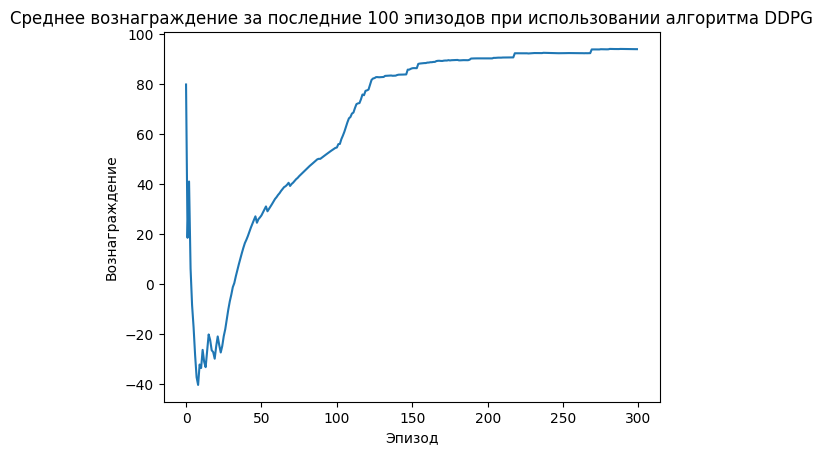

In [332]:
plt.plot(avg_rewards_last_100_episodes)
plt.title('Среднее вознаграждение за последние 100 эпизодов при использовании алгоритма DDPG')
plt.xlabel('Эпизод')
plt.ylabel('Вознаграждение')
plt.show()

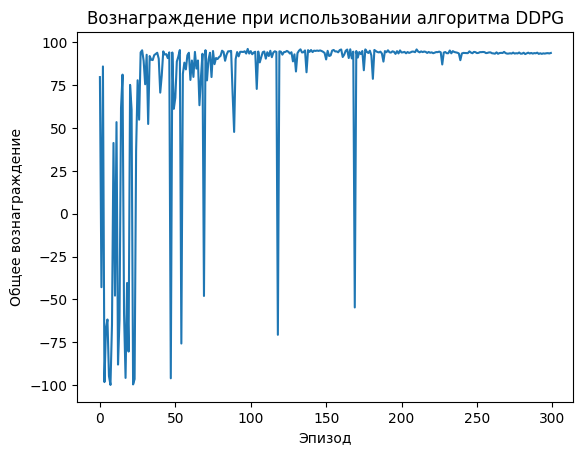

In [333]:
plt.plot(total_rewards)
plt.title('Вознаграждение при использовании алгоритма DDPG')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

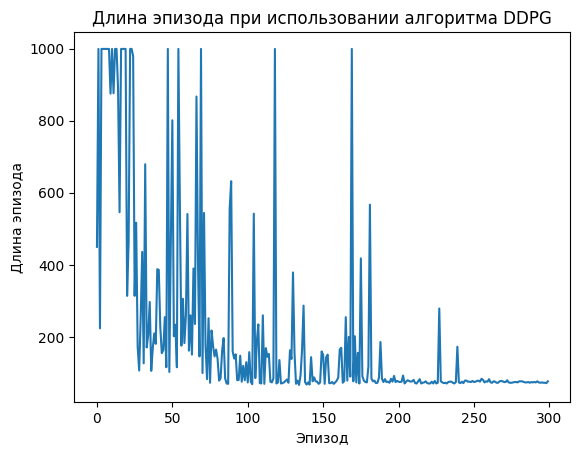

In [334]:
plt.plot(lengths)
plt.title('Длина эпизода при использовании алгоритма DDPG')
plt.xlabel('Эпизод')
plt.ylabel('Длина эпизода')
plt.show()